In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
from pprint import pprint
import scienceplots
import sys
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from utils import benchmark

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - time_window - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,test_obs
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent

df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

In [2]:

INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=False,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature =True)

processed = fe.preprocess_data(df_dax)
processed = processed.fillna(0)
processed= processed.replace(np.inf,0)
train_data= data_split(processed, DATA_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)


Successfully added user defined features


In [17]:
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2024-10-01'

In [18]:
train_data= data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)

In [ ]:
recession_result = benchmark(train_data,test_data,50_000,1,['close','return'],INDICATORS,save=True,tag='return_vector_log_return_reward_recession',reward_sortino=True)

In [20]:
recession_result_sharp = benchmark(train_data,test_data,50_000,1,['close','return'],INDICATORS,save=True,tag='sharpe_return_vector_log_return_reward_recession',reward_sharpe=True)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_16
--------------------------------------
| time/              |               |
|    fps             | 20            |
|    iterations      | 1             |
|    time_elapsed    | 99            |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0059424336 |
--------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 201         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008619024 |
|    clip_fraction        | 0.0354      |
|    clip_range           | 0.2         |
|    entropy_loss         

In [28]:
recession_result_log_return = benchmark(train_data,test_data,1000,1,['close','return'],INDICATORS,save=True,tag='log_return_vector_log_return_reward_recession')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_21
-------------------------------------
| time/              |              |
|    fps             | 155          |
|    iterations      | 1            |
|    time_elapsed    | 13           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0027556564 |
-------------------------------------
Logging to ./data/tb\ppo_22
------------------------------------
| time/              |             |
|    fps             | 144         |
|    iterations      | 1           |
|    time_elapsed    | 14          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.004125893 |
------------------------------------
Initial portfolio value:1000000
Final portfolio value: 1511941.75
Final accumulative portfolio

In [22]:
from utils import baseline


mvo = baseline(processed,INDICATORS,TEST_START_DATE,TEST_END_DATE)

begin_total_asset:50000
end_total_asset:59976.84123225947
Sharpe:  1.0454785311812973
Test Finished!
episode_return 1.1995368246451894
begin_total_asset:1000000
end_total_asset:1108365.0361304719
Sharpe:  0.47609094494754345
Test Finished!
episode_return 1.1083650361304718
begin_total_asset:1000000
end_total_asset:1108365.0361304719
Sharpe:  0.47609094494754345
Test Finished!
episode_return 1.1083650361304718


In [32]:
recession_result_dax_sortino = benchmark(train_data,test_data,50_000,1,['close','return'],INDICATORS,save=True,tag='return_vector_log_return_reward_recession',reward_sortino=True)
recession_result_dax_sharpe = benchmark(train_data,test_data,50_000,1,['close','return'],INDICATORS,save=True,tag='return_vector_log_return_reward_recession',reward_sharpe=True)


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_23
-------------------------------------
| time/              |              |
|    fps             | 22           |
|    iterations      | 1            |
|    time_elapsed    | 90           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.007429121 |
-------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 22            |
|    iterations           | 2             |
|    time_elapsed         | 183           |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.006466236   |
|    clip_fraction        | 0.0116        |
|    clip_range           | 0.2           |
|    entropy_lo

ValueError: Expected parameter loc (Tensor of shape (1, 3)) of distribution Normal(loc: torch.Size([1, 3]), scale: torch.Size([1, 3])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0')

In [29]:
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2006-12-30'
TEST_START_DATE = '2007-01-01'
TEST_END_DATE = '2008-12-31'

INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=False,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature =True)

processed = fe.preprocess_data(df_dow)
processed = processed.fillna(0)
processed= processed.replace(np.inf,0)
train_data= data_split(processed, DATA_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)

Successfully added user defined features


In [30]:
train_data.tic.unique()

array(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CVX', 'DIS', 'HD', 'HON',
       'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT',
       'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'WBA', 'WMT'], dtype=object)

In [11]:
train_data.tic.unique()

array(['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMAT', 'AMD', 'AMGN',
       'CDNS', 'CMCSA', 'COST', 'CSX', 'CTAS', 'EA', 'FAST', 'HAS',
       'INTC', 'JBHT', 'KLAC', 'LRCX', 'MNST', 'MSFT', 'MU', 'PAYX',
       'PCAR', 'PEP', 'ROST', 'SWKS', 'TXN', 'WBA', 'WDC', 'XEL'],
      dtype=object)

In [14]:
recession_result_dax_sortino = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession',reward_sortino=True)


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_27
Initial portfolio value:1000000
Final portfolio value: 1776396.75
Final accumulative portfolio value: 1.77639675
Maximum DrawDown: -0.4911439190751282
Sharpe ratio: 0.40735133630416054
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 2.01e+03    |
|    ep_rew_mean     | 60.3        |
| time/              |             |
|    fps             | 17          |
|    iterations      | 1           |
|    time_elapsed    | 118         |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.04306305 |
------------------------------------
Initial portfolio value:1000000
Final portfolio value: 1535482.0
Final accumulative portfolio value: 1.535482
Maximum DrawDown: -0.5335042402381374
Sharpe ratio: 0.3366

In [16]:
recession_result_dax = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_return')
recession_result_dax_sharpe = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_sharpe',reward_sharpe=True)


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_30
Initial portfolio value:1000000
Final portfolio value: 1772771.125
Final accumulative portfolio value: 1.772771125
Maximum DrawDown: -0.4971671873416902
Sharpe ratio: 0.4053166203272813
-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 2.01e+03     |
|    ep_rew_mean     | 0.568        |
| time/              |              |
|    fps             | 45           |
|    iterations      | 1            |
|    time_elapsed    | 45           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0007451379 |
-------------------------------------
Initial portfolio value:1000000
Final portfolio value: 1691494.375
Final accumulative portfolio value: 1.691494375
Maximum DrawDown: -0.44469747342514865
S

In [19]:
recession_result_dax_sortino = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_2010_2024',reward_sortino=True)
recession_result_dax = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_return_2010_2024')
recession_result_dax_sharpe = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_sharpe_2010_2024',reward_sharpe=True)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_34
------------------------------------
| time/              |             |
|    fps             | 18          |
|    iterations      | 1           |
|    time_elapsed    | 108         |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.010134793 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 220          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0075170984 |
|    clip_fraction        | 0.0359       |
|    clip_range           | 0.2          |
|    entropy_loss         | -46.9 

In [22]:
results = [recession_result_dax_sortino,recession_result_dax,recession_result_dax_sharpe]

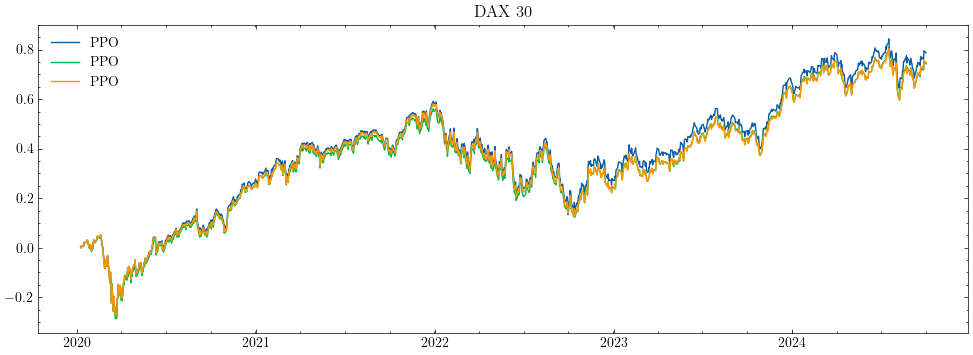

In [28]:
%matplotlib inline

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(results): 
            plt.plot(item[0]['test'][0].get('date'),((item[0]['test'][0].get('account').pct_change()+ 1 ).cumprod())-1,label=str(item[0]['name']).upper())
    plt.legend()
    plt.title('NASDAQ')
    plt.show()


In [20]:
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2024-10-01'

INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=False,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature =True)

processed = fe.preprocess_data(df_hsi)
processed = processed.fillna(0)
processed= processed.replace(np.inf,0)
train_data= data_split(processed, DATA_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)


Successfully added user defined features


In [ ]:
recession_result_dax_sortino = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_2020_2024_hsi',reward_sortino=True)
recession_result_dax = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_return_2020_2024_hsi')
recession_result_dax_sharpe = benchmark(train_data,test_data,50_000,5,['close','return'],INDICATORS,save=True,tag='nasdaq_recession_sharpe_2020_2024_hsi',reward_sharpe=True)